### Trying the XGBoost modelling procedure on the case study data

In [1]:
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import xgboost as xgb
import shap
import pickle


In [2]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples = 5000, n_features = 40, n_informative = 3, 
            n_redundant  = 2, n_classes = 2, n_repeated = 0, n_clusters_per_class = 3, weights = None, flip_y = 0.05, class_sep = 0.1, hypercube = True, shift = 0.0, scale = 1.0, shuffle = True, random_state = 2)

In [3]:
#y.mean()
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 24)

### Early Stopping

In [4]:
xgb_model_1 = xgb.XGBClassifier(n_estimators = 1000, verbosity = 1, use_label_encoder = False,
                        objective = 'binary:logistic', learning_rate = 0.3, eval_metric = 'auc', early_stopping_rounds = 30)

In [5]:
%%time
fit_params = {
    'verbose': True,
    'eval_set':[(X_train, y_train),(X_val, y_val)]

}

xgb_model_1.fit(X_train, y_train, **fit_params)

[0]	validation_0-auc:0.79886	validation_1-auc:0.74582
[1]	validation_0-auc:0.83943	validation_1-auc:0.77806
[2]	validation_0-auc:0.85567	validation_1-auc:0.78666
[3]	validation_0-auc:0.86581	validation_1-auc:0.79483
[4]	validation_0-auc:0.86995	validation_1-auc:0.80104
[5]	validation_0-auc:0.87903	validation_1-auc:0.80655


c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:32:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-auc:0.88457	validation_1-auc:0.80942
[7]	validation_0-auc:0.89101	validation_1-auc:0.80683
[8]	validation_0-auc:0.90195	validation_1-auc:0.80446
[9]	validation_0-auc:0.91453	validation_1-auc:0.80301
[10]	validation_0-auc:0.92210	validation_1-auc:0.79635
[11]	validation_0-auc:0.92814	validation_1-auc:0.79687
[12]	validation_0-auc:0.93055	validation_1-auc:0.79831
[13]	validation_0-auc:0.93327	validation_1-auc:0.79755
[14]	validation_0-auc:0.93786	validation_1-auc:0.79818
[15]	validation_0-auc:0.93935	validation_1-auc:0.80004
[16]	validation_0-auc:0.94562	validation_1-auc:0.79783
[17]	validation_0-auc:0.95269	validation_1-auc:0.79787
[18]	validation_0-auc:0.95388	validation_1-auc:0.79829
[19]	validation_0-auc:0.96270	validation_1-auc:0.79224
[20]	validation_0-auc:0.96726	validation_1-auc:0.79184
[21]	validation_0-auc:0.96915	validation_1-auc:0.79110
[22]	validation_0-auc:0.97066	validation_1-auc:0.78916
[23]	validation_0-auc:0.97210	validation_1-auc:0.78728
[24]	validatio

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=30,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

#### Examining model performance

In [6]:
# Evaluating the ROC auc on the validation set
# 1. Obtain the predicted brobabilities
val_set_pred_prob = xgb_model_1.predict_proba(X_val)[:,1]

In [7]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, val_set_pred_prob)

0.8094162508652802

In [8]:
xgb_model_1.get_booster().attributes()

{'best_iteration': '6', 'best_score': '0.8094162508652804'}

### Tuning the learning rate

In [9]:
learning_rates = np.linspace(start = 0.01, stop = 1, num = 25)

In [10]:
%%time
val_aucs = []
best_iters = []
for learning_rate in learning_rates:
    xgb_model_1.set_params(**{'learning_rate':learning_rate})
    fit_params = {
    'verbose': False,
    'eval_set':[(X_train, y_train),(X_val, y_val)]

    }

    xgb_model_1.fit(X_train, y_train, **fit_params)
    val_set_pred_proba_2 = xgb_model_1.predict_proba(X_val)[:,1]
    val_aucs.append(roc_auc_score(y_val, val_set_pred_proba_2))
    best_iters.append(int(xgb_model_1.get_booster().attributes()['best_iteration']))

c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:32:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:32:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:32:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core

CPU times: total: 49.7 s
Wall time: 14.9 s


In [11]:
learning_rates_df = pd.DataFrame({'learning_rate':learning_rates, 'Validation AUC':val_aucs, 'Best iteration':best_iters})

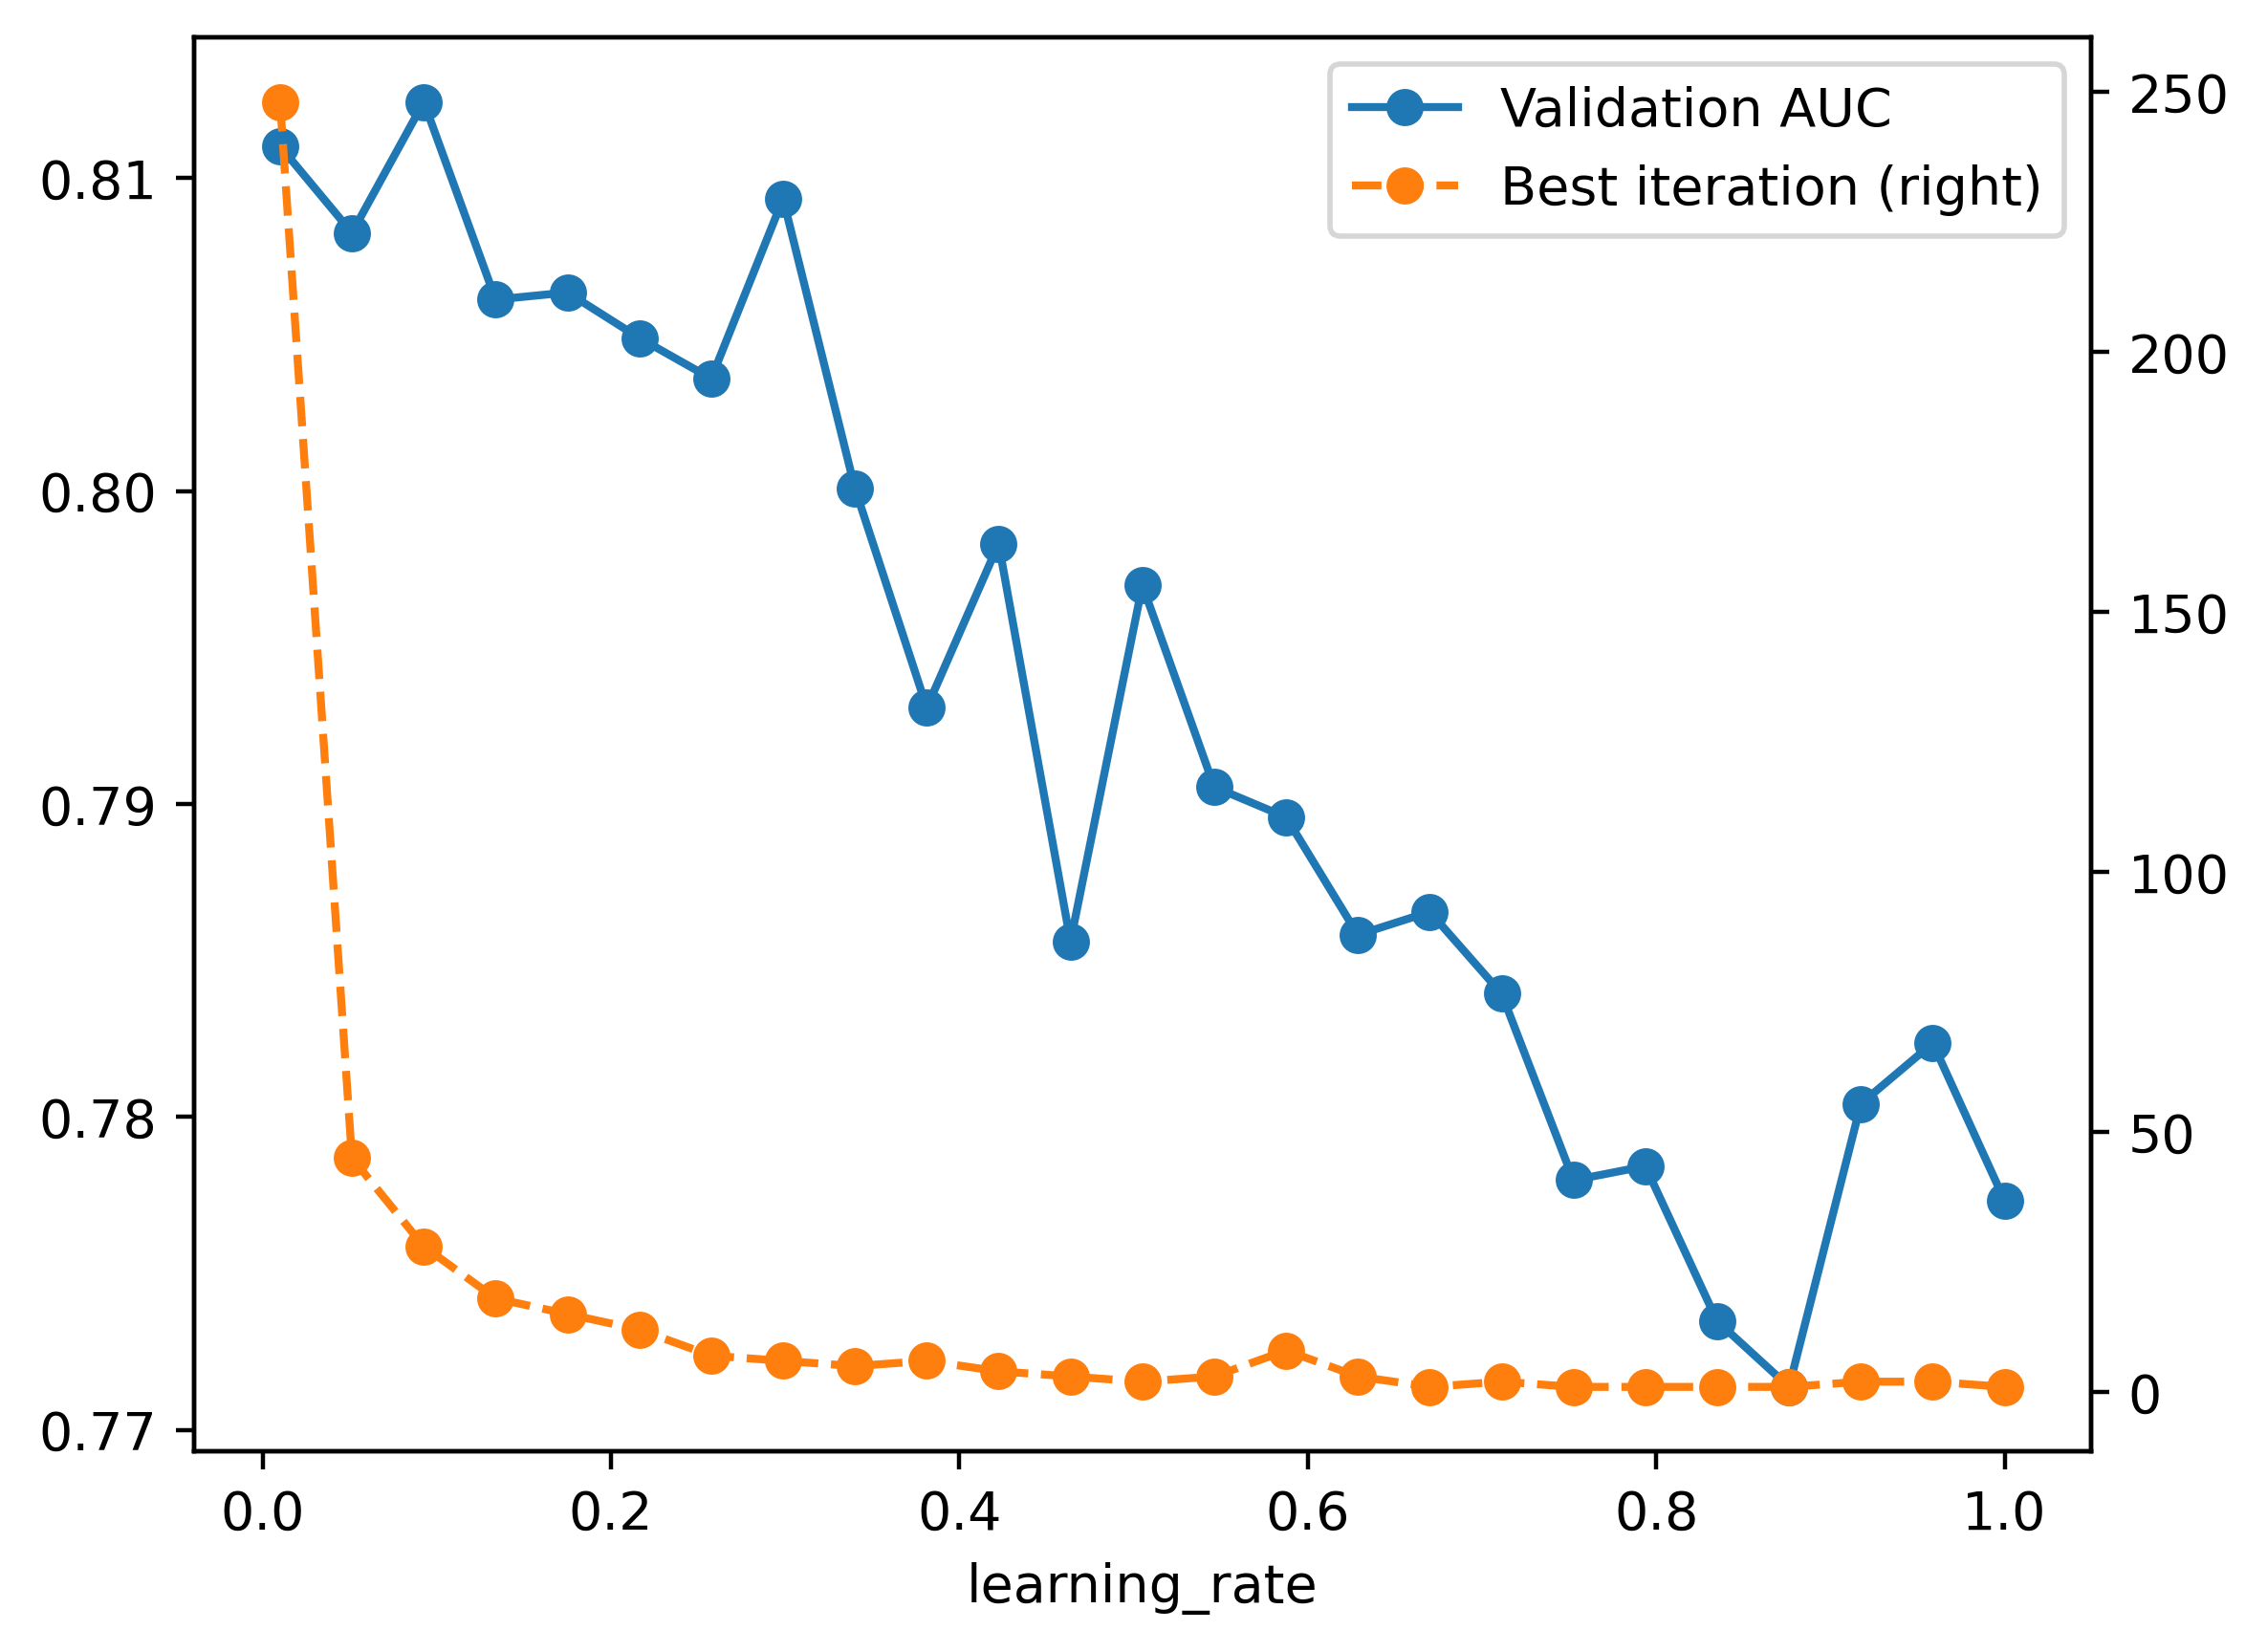

In [12]:
learning_rates_df.set_index('learning_rate').plot(secondary_y = 'Best iteration', style = ['-o', '--o'])
plt.show()

In [13]:
max(val_aucs)

0.8124312277177805

#### Implementing a grid search over ranges of six hyperparameters

In [14]:
from scipy.stats import uniform
param_grid = {'max_depth':[2,3,4,5,6,7], 'gamma':uniform(loc = 0.0, scale = 3), 'min_child_weight':list(range(1,151)),
        'colsample_bytree':uniform(loc = 0.1, scale = 0.9), 'subsample':uniform(loc = 0.5, scale = 0.5), 'learning_rate':uniform(loc = 0.01, scale = 0.5)}

In [15]:
from sklearn.model_selection import ParameterSampler
rng = np.random.RandomState(0)
n_iter = 1000
param_list = list(ParameterSampler(param_grid, n_iter = n_iter, random_state = rng))

In [16]:
param_list[0]

{'colsample_bytree': 0.5939321535345923,
 'gamma': 2.1455680991172583,
 'learning_rate': 0.31138168803582195,
 'max_depth': 5,
 'min_child_weight': 104,
 'subsample': 0.7118273996694524}

In [17]:
xgb_model_2 = xgb.XGBClassifier(n_estimators = 1000, verbosity = 1, use_label_encoder = False,
            objective = 'binary:logistic', eval_metric = 'auc', earling_stopping_rounds = 30)
xgb_model_1.set_params(**param_list[0])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5939321535345923, device=None,
              early_stopping_rounds=30, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=2.1455680991172583,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.31138168803582195,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=104, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [20]:
%%time
# Using a loop to look at all the hyperparameter values
val_aucs = []
counter = 1
for params in param_list:
    #Set hyperparameters and fit model
    xgb_model_2.set_params(**params)
    xgb_model_2.fit(X_train, y_train, **fit_params)
    #Get the predicted probabilities and save validation ROC AUC
    val_set_pred_proba = xgb_model_2.predict_proba(X_val)[:,1]
    val_aucs.append(roc_auc_score(y_val, val_set_pred_proba))
    if counter % 50 == 0:
        print("Done with {counter} of {n_iter}".format(counter = counter, n_iter = n_iter))
    counter += 1


c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:34:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:34:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:34:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warn

Done with 50 of 1000


c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:37:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:37:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:37:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warn

Done with 100 of 1000


c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:40:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:40:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:40:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warn

Done with 150 of 1000


c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:44:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:44:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:44:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warn

Done with 200 of 1000


c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:47:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:47:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:47:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warn

Done with 250 of 1000


c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:50:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:50:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:50:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warn

Done with 300 of 1000


c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:53:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:53:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:53:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warn

Done with 350 of 1000


c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:57:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:57:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:57:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warn

Done with 400 of 1000


c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:00:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:00:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:00:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warn

Done with 450 of 1000


c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:03:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:03:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:03:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warn

Done with 500 of 1000


c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:06:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:06:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:06:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warn

Done with 550 of 1000


c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:09:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:09:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:09:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warn

Done with 600 of 1000


c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:12:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:12:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:12:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warn

Done with 650 of 1000


c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:15:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:15:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:15:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warn

Done with 700 of 1000


c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:18:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:18:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:18:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warn

Done with 750 of 1000


c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:21:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:21:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:22:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warn

Done with 800 of 1000


c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:25:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:25:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:25:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warn

Done with 850 of 1000


c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:28:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:28:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:28:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warn

Done with 900 of 1000


c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:31:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:31:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warn

Done with 950 of 1000


c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:34:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:34:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:34:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "earling_stopping_rounds", "use_label_encoder" } are not used.

  warn

Done with 1000 of 1000
CPU times: total: 3h 13min 14s
Wall time: 1h 3min 46s


In [22]:
xgb_param_search_df = pd.DataFrame(param_list)

In [33]:
xgb_param_search_df.head()

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample,Validation ROC AUC
0,0.593932,2.145568,0.311382,5,104,0.711827,0.745289
1,0.681305,1.312762,0.455887,2,141,0.691721,0.725087
2,0.812553,1.586685,0.294022,7,26,0.535518,0.734290
3,0.178416,0.060655,0.426310,2,83,0.736804,0.712323
4,0.820820,1.561432,0.349440,2,10,0.768687,0.750191


In [24]:
# xgb_param_search_df['Training ROC AUC'] = train_aucs
xgb_param_search_df['Validation ROC AUC'] = val_aucs

In [25]:
max_auc = xgb_param_search_df['Validation ROC AUC'].max()
max_auc

0.8025160151889212

C:\Users\HI\AppData\Local\Temp\ipykernel_3620\39091360.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = tmp_df.groupby('param_decile').agg(
C:\Users\HI\AppData\Local\Temp\ipykernel_3620\39091360.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = tmp_df.groupby('param_decile').agg(
C:\Users\HI\AppData\Local\Temp\ipykernel_3620\39091360.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df 

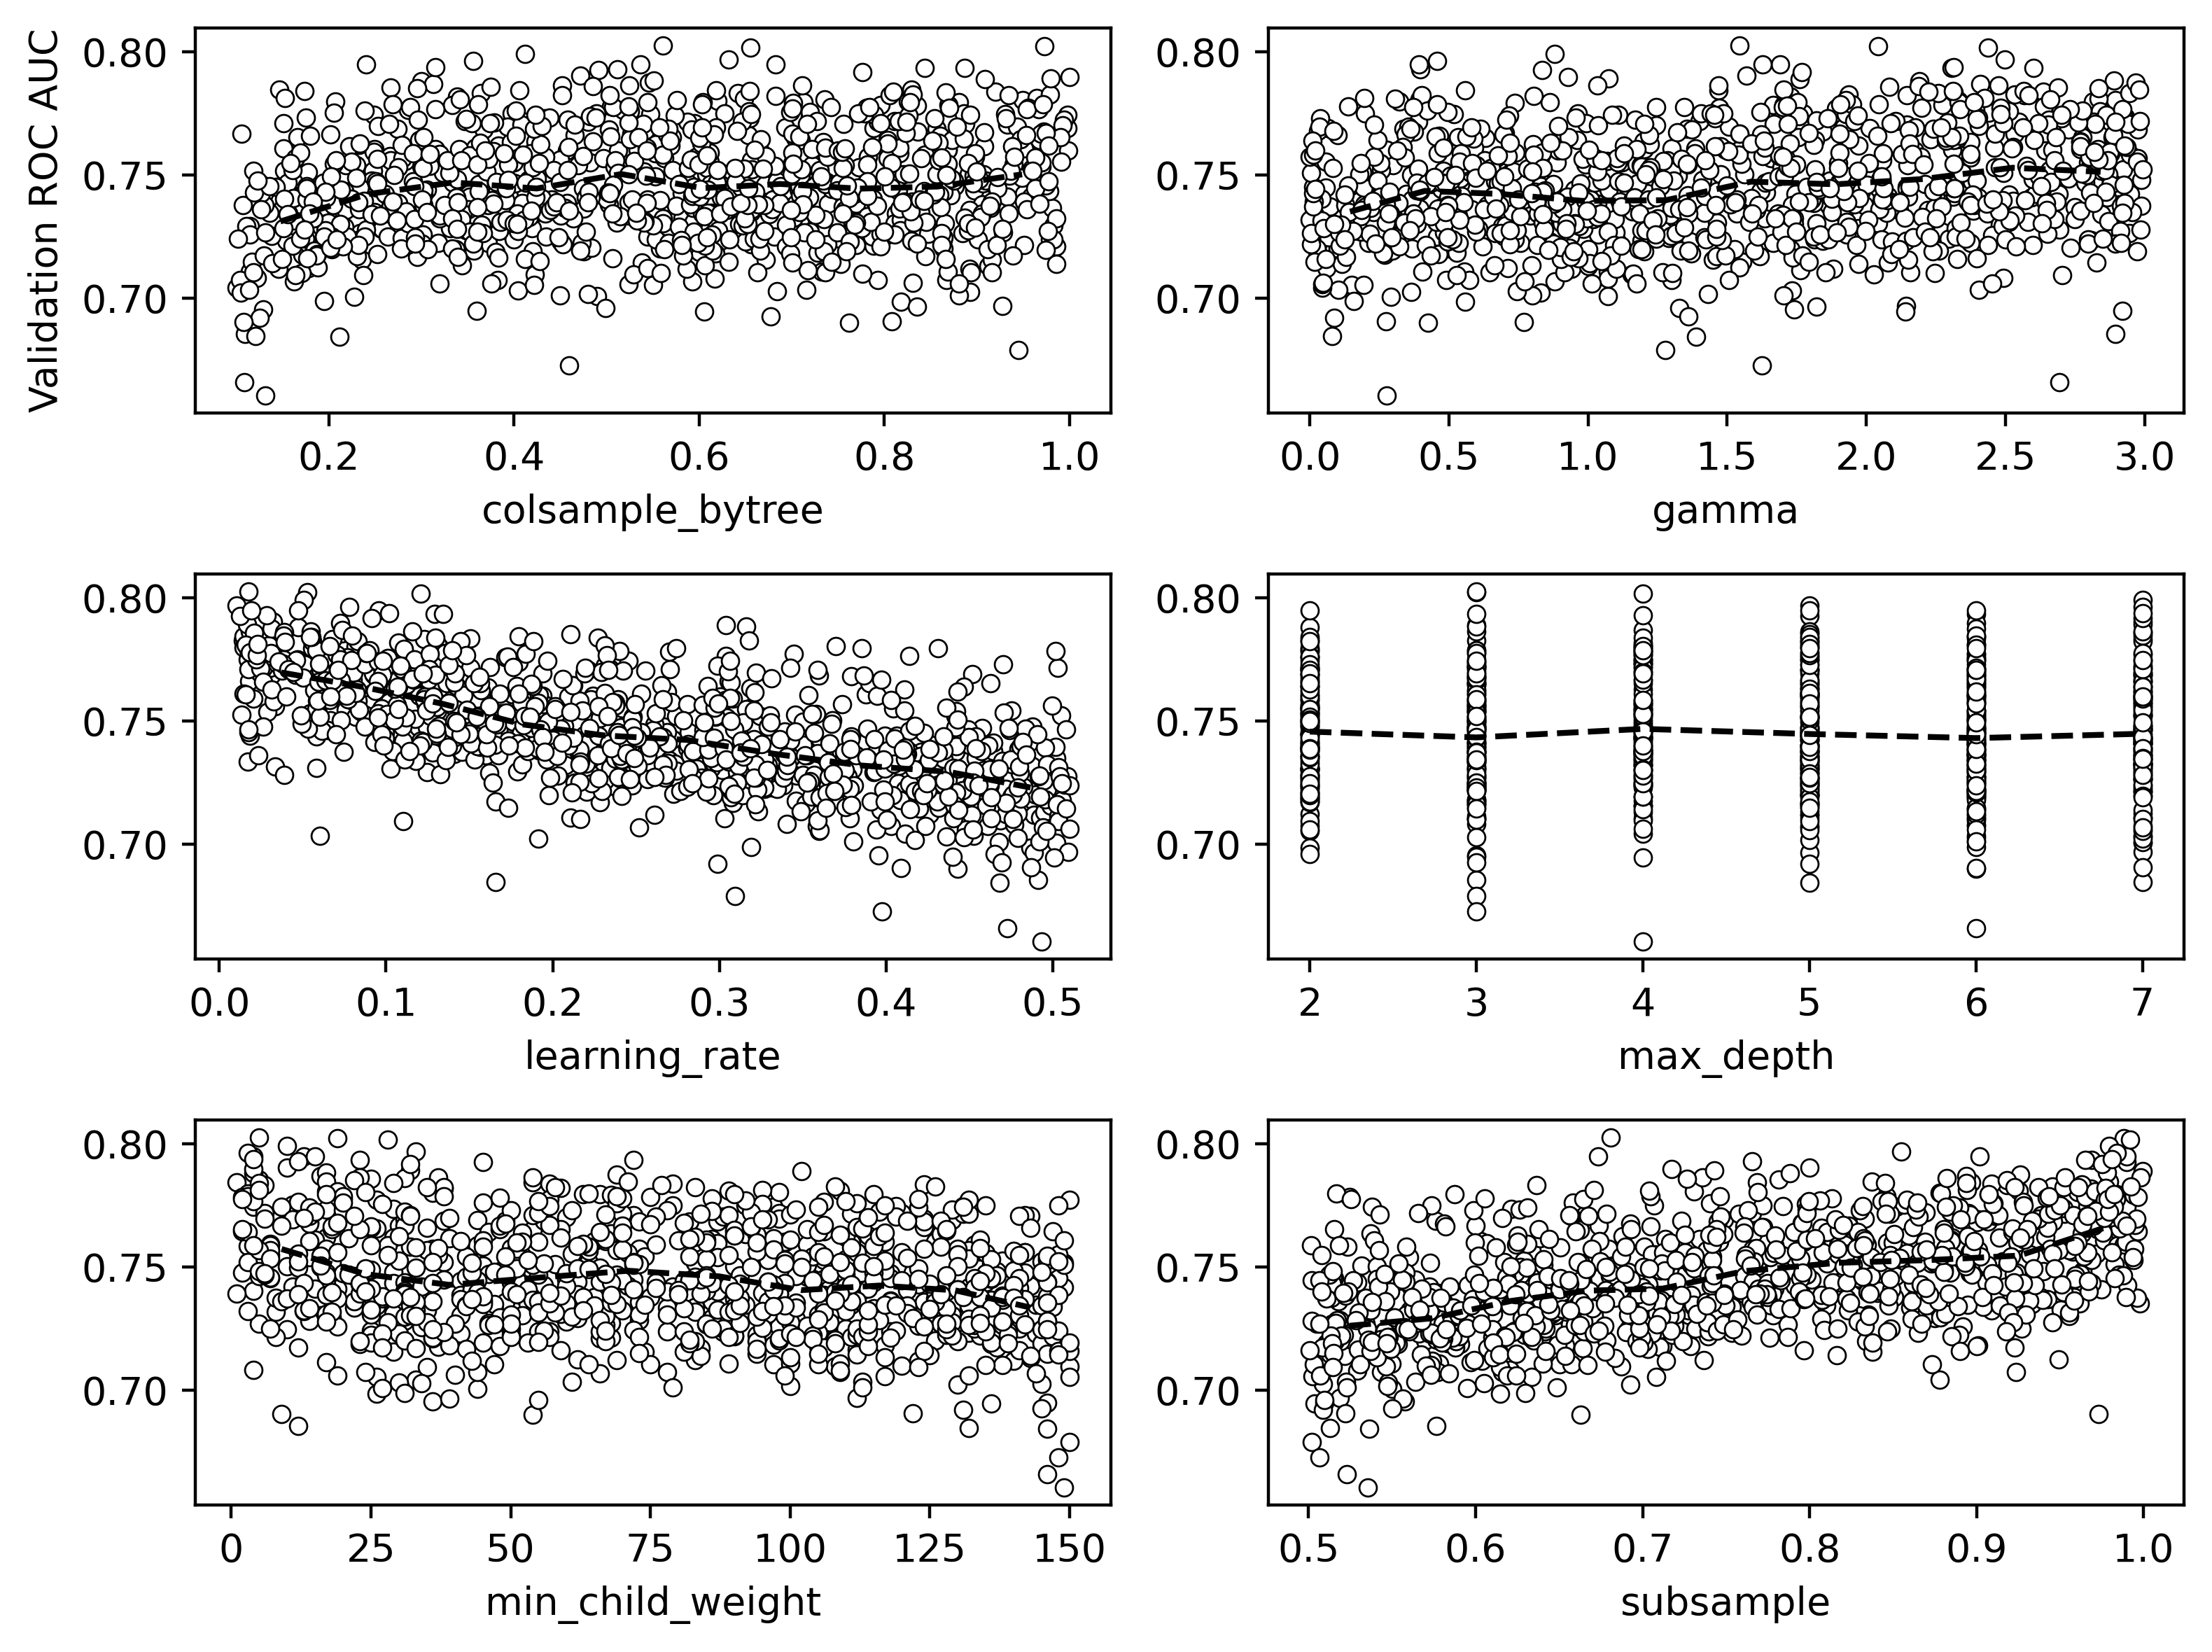

In [30]:
mpl.rcParams['figure.dpi'] = 400
fig, axs = plt.subplots(3,2,figsize=(8,6))
counter = 0
for col in xgb_param_search_df.columns[:-1]:
#     print(col)
    this_ax = axs.flatten()[counter]
    xgb_param_search_df.plot.scatter(
        x=col, y='Validation ROC AUC',
        ax=this_ax, marker='o',
        color='w',
        edgecolor='k',
        linewidth=0.5)
    
    if counter > 0:
        this_ax.set_ylabel('')
    counter += 1
    
    if col != 'max_depth':
        out, bins = pd.qcut(xgb_param_search_df[col], q=10,
                            retbins=True, duplicates='drop')
        half_points = [(bins[ix] + bins[ix+1])/2
                       for ix in range(len(bins)-1)]
    else:
        out = xgb_param_search_df[col]
        half_points = np.sort(xgb_param_search_df[col].unique())
        
    tmp_df = xgb_param_search_df.copy()
    tmp_df['param_decile'] = out
    mean_df = tmp_df.groupby('param_decile').agg(
        {'Validation ROC AUC':'mean'})
    
    this_ax.plot(half_points, mean_df.values, color='k', linestyle='--')
plt.tight_layout()
plt.show()

In [28]:
max_ix = xgb_param_search_df['Validation ROC AUC'] == max_auc
xgb_param_search_df[max_ix]

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample,Validation ROC AUC
322,0.561133,1.543828,0.01745,3,5,0.680686,0.802516


In [29]:
param_list[np.where(max_ix)[0][0]]


{'colsample_bytree': 0.5611328485091501,
 'gamma': 1.543827929043955,
 'learning_rate': 0.01745000375220706,
 'max_depth': 3,
 'min_child_weight': 5,
 'subsample': 0.6806856240493216}